In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu
import PolyBin3D as pb

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils

%load_ext autoreload
%autoreload 2

2025-05-19 13:30:18.274097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 13:30:18.507141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 13:30:18.507182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 13:30:18.530688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 13:30:18.606588: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [4]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
#fn_fields_zspace = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_zspace_deconvolved_{idx_LH}.npy'

bias_terms_eul = np.load(fn_fields)
#bias_terms_eul_zspace = np.load(fn_fields_zspace)

In [5]:
#the order is b1, b2, bs2, blaplacian
bias_params = [1, 0.5, 0.5, 0.5]
# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field_eul_norm = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [6]:
boxsize = 1000 # Mpc/h
n_grid = 128 

In [7]:
# Load the PolyBin3D class 
base = pb.PolyBin3D([boxsize, boxsize, boxsize], n_grid, 
                 #boxcenter=[0,0,0], # center of the simulation volume
                 #pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs ('fftw' for cpu, 'jax' for gpu)
                 nthreads=4, # number of CPUs for performing FFTs (only applies to 'fftw' backend)
                 sightline='global', # line-of-sight [global = z-axis, local = relative to pair]
                )


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend


In [ ]:
# Define some k-bins and ell_max
#k_edges = np.arange(0.01,0.41,0.05)
k_edges = np.linspace(0.01, 0.4, 8) # 7 bins
k_edges_squeeze = k_edges.copy()
#k_edges_squeeze = np.arange(0.01,0.15,0.02) # add extra high-k bins for squeezed triangles
lmax = 1

# Load the bispectrum class
bspec = pb.BSpec(base, 
                 k_edges, # one-dimensional bin edges
                 applySinv = None, # weighting function [only needed for unwindowed estimators]
                 mask = None, # real-space mask
                 lmax = lmax, # maximum Legendre multipole
                 k_bins_squeeze = k_edges_squeeze, # squeezed bins
                 include_partial_triangles = False, # whether to include bins whose centers do not satisfy triangle conditions
                )


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant


In [49]:
bk_corr = bspec.Bk_ideal(tracer_field_eul_norm, discreteness_correction=True)

Computing degeneracy factor
Computing ideal Fisher matrix


In [50]:
k123 = bspec.get_ks()
weight = k123.prod(axis=0)
print(weight)

[4.2875000e-05 2.5287500e-04 6.3787500e-04 1.1978750e-03 1.9328750e-03
 2.8428750e-03 3.9278750e-03 6.1412500e-04 9.7537500e-04 1.5491250e-03
 2.1228750e-03 2.9091250e-03 3.6953750e-03 4.6941250e-03 5.6928750e-03
 6.9041250e-03 8.1153750e-03 9.5391250e-03 2.4603750e-03 3.3716250e-03
 4.2828750e-03 4.6203750e-03 5.8691250e-03 7.1178750e-03 7.4553750e-03
 9.0416250e-03 1.0627875e-02 1.0965375e-02 1.2889125e-02 1.5150375e-02
 6.3316250e-03 8.0428750e-03 9.7541250e-03 1.1465375e-02 1.0216625e-02
 1.2390375e-02 1.4564125e-02 1.5026625e-02 1.7662875e-02 2.0761625e-02
 1.2977875e-02 1.5739125e-02 1.8500375e-02 1.9087875e-02 2.2436625e-02
 2.6372875e-02 2.3149125e-02 2.7210375e-02 3.1984125e-02 3.7595375e-02]


/tmp/ipykernel_2214097/3140736496.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


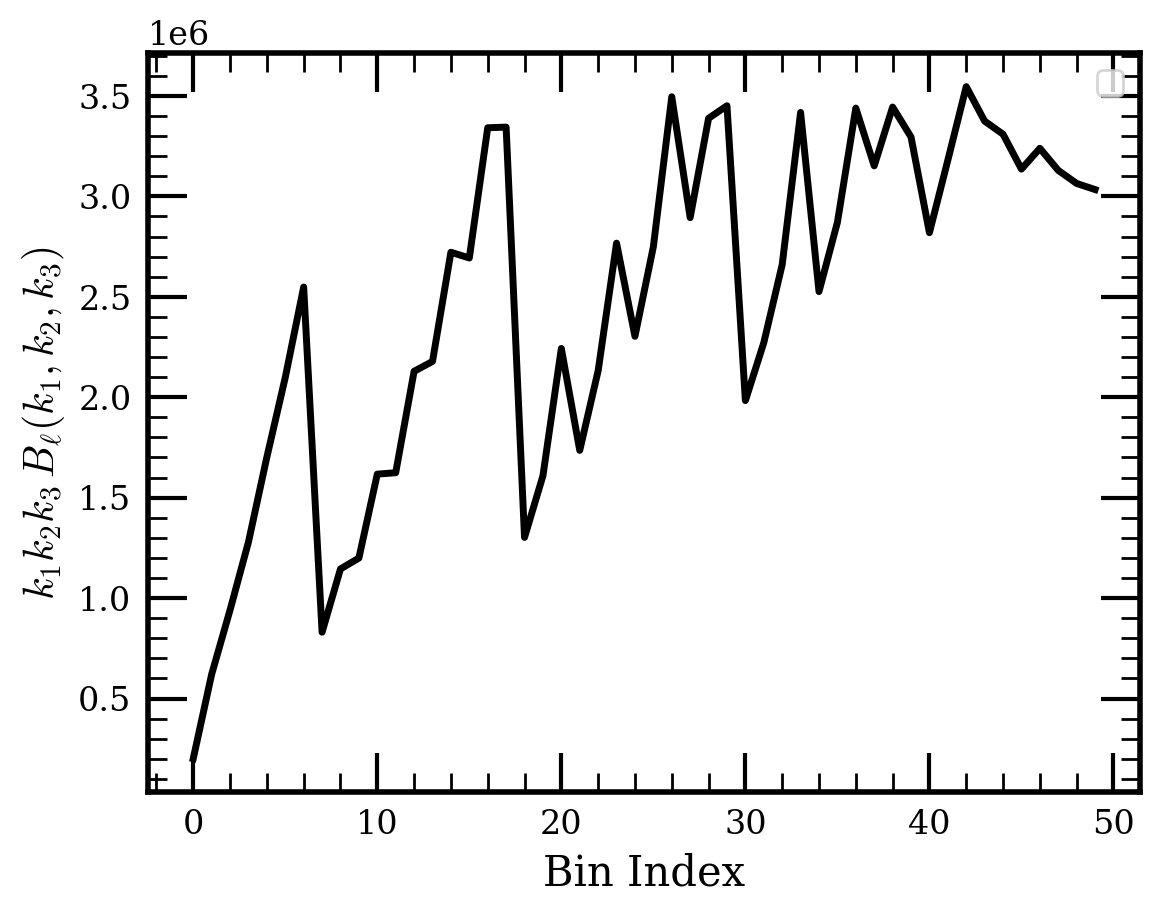

In [51]:
# need to un-normalize bc the field was already normalized, and the 
# bispec code is doing extra normalization
norm = n_grid**3
# cube the norm because it's the bispectrum
plt.plot(norm**3 * weight*bk_corr['b0'],c='k')
    #plt.plot(weight*bk_uncorr['b%d'%l],c=cs[l//2],ls='--')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)

/tmp/ipykernel_2214097/1518504781.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12);


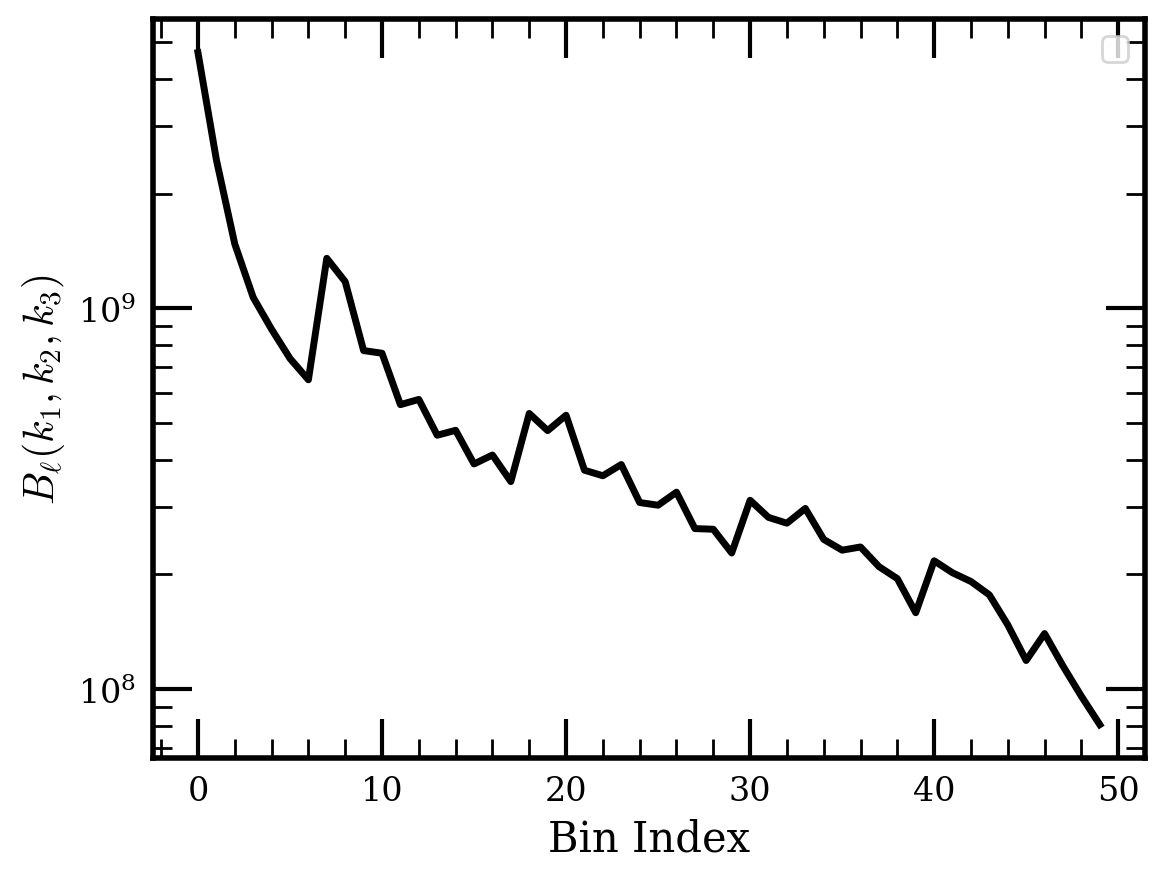

In [52]:
plt.plot(norm**3 * bk_corr['b0'],c='k')
    #plt.plot(weight*bk_uncorr['b%d'%l],c=cs[l//2],ls='--')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.yscale('log')
plt.legend(fontsize=12);

In [53]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.41,0.05)
k_edges_squeeze = k_edges.copy()
#k_edges_squeeze = np.arange(0.01,0.15,0.02) # add extra high-k bins for squeezed triangles
lmax = 1

def compute_bispectrum(base, tracer_field, k_edges, k_edges_squeeze, lmax):
    # Load the bispectrum class
    bspec = pb.BSpec(base, 
                    k_edges, # one-dimensional bin edges
                    applySinv = None, # weighting function [only needed for unwindowed estimators]
                    mask = None, # real-space mask
                    lmax = lmax, # maximum Legendre multipole
                    k_bins_squeeze = k_edges_squeeze, # squeezed bins
                    include_partial_triangles = False, # whether to include bins whose centers do not satisfy triangle conditions
                    )
    
    bk_corr = bspec.Bk_ideal(tracer_field, discreteness_correction=True)

    return bspec, bk_corr

In [54]:
bias_params = [1, 0.5, 0.5, 0.5]
bspecs = []
bks = []

### loop over some LHs
idxs_LH = np.arange(0,10)
for idx_LH in idxs_LH:
    print(f'idx_LH = {idx_LH}')
    fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
    bias_terms_eul = np.load(fn_fields)
    tracer_field_eul_norm = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

    bspec, bk_corr = compute_bispectrum(base, tracer_field_eul_norm, k_edges, k_edges_squeeze, lmax)
    bspecs.append(bspec)
    bks.append(bk_corr)

idx_LH = 0

Binning: 7 bins in [0.010, 0.360] h/Mpc
Squezed binning: 7 bins in [0.010, 0.360] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
idx_LH = 1

Binning: 7 bins in [0.010, 0.360] h/Mpc
Squezed binning: 7 bins in [0.010, 0.360] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
idx_LH = 2

Binning: 7 bins in [0.010, 0.360] h/Mpc
Squezed binning: 7 bins in [0.010, 0.360] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
idx_LH = 3

Binning: 7 bins in [0.010, 0.360] h/Mpc
Squezed binning: 7 bins in [0.010, 0.360] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
idx_LH = 4

Binning: 7 bins in [0.010, 0.360] h/Mpc
Squezed binning: 7 bins in [0.010, 0.360] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
idx_LH = 5

Binning: 7 bins in [0.0

/tmp/ipykernel_2214097/1023481053.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


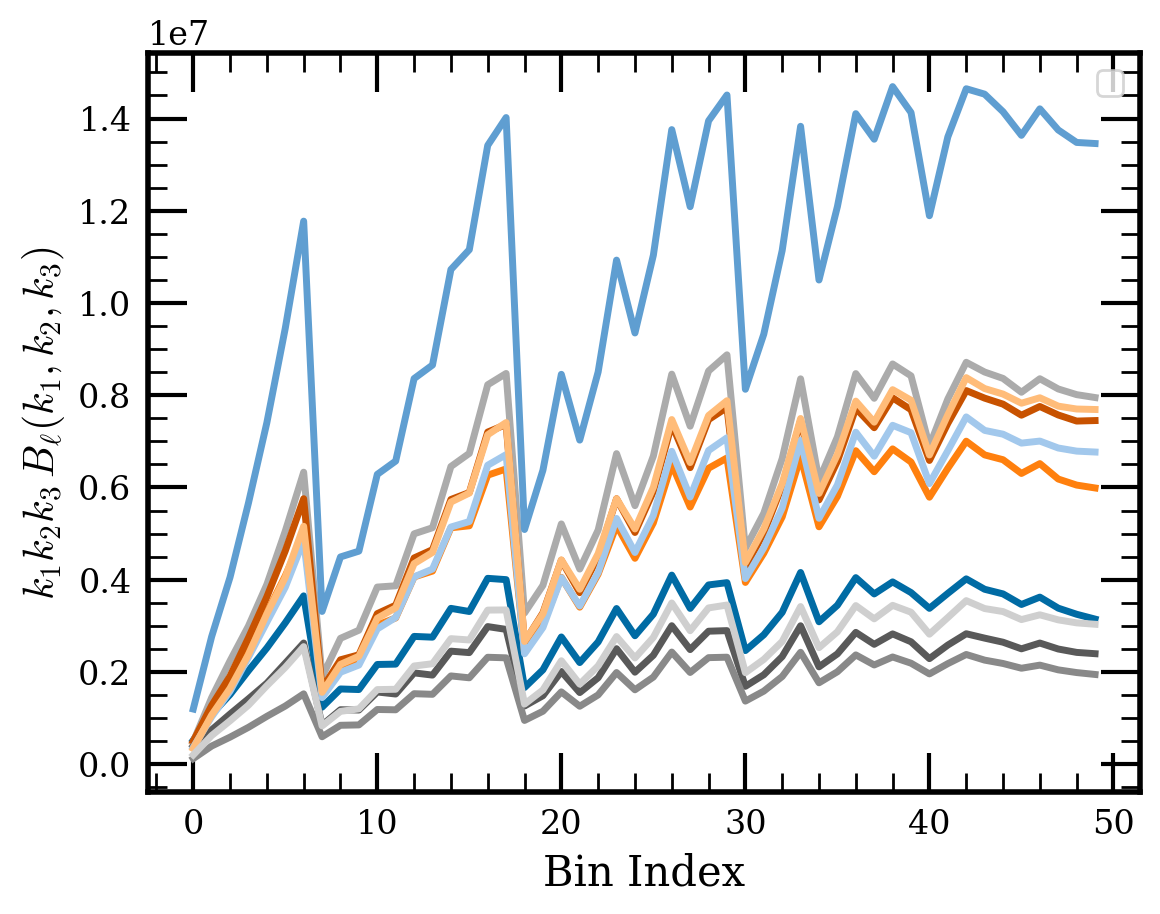

In [55]:
norm = n_grid**3

for bspec, bk in zip(bspecs, bks):
    
    k123 = bspec.get_ks()
    weight = k123.prod(axis=0)

    # need to un-normalize bc the field was already normalized, and the 
    # bispec code is doing extra normalization
    # cube the norm because it's the bispectrum
    plt.plot(norm**3 * weight*bk['b0'])
        #plt.plot(weight*bk_uncorr['b%d'%l],c=cs[l//2],ls='--')
        
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        


/tmp/ipykernel_2214097/2045013214.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


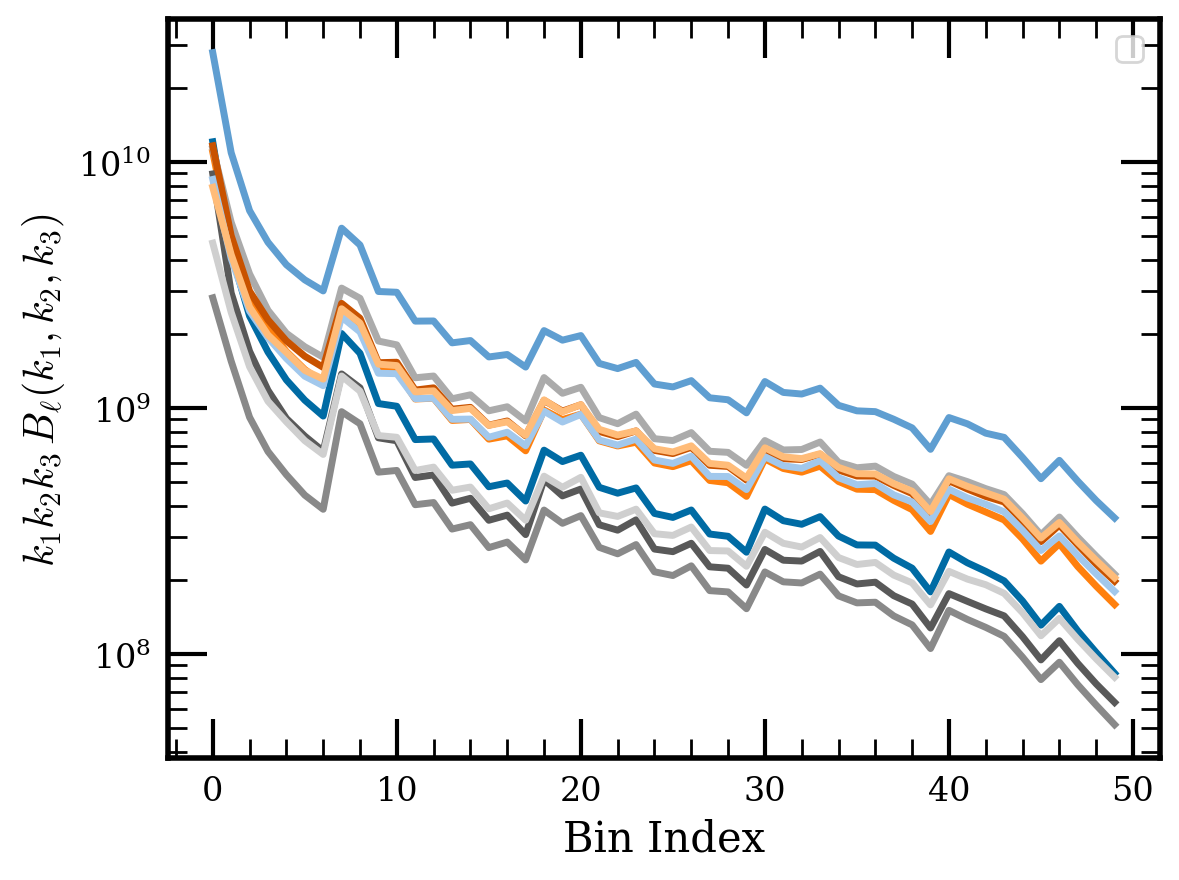

In [ ]:
norm = n_grid**3

for bspec, bk in zip(bspecs, bks):
    
    k123 = bspec.get_ks()
    weight = k123.prod(axis=0)

    # need to un-normalize bc the field was already normalized, and the 
    # bispec code is doing extra normalization
    # cube the norm because it's the bispectrum
    plt.plot(norm**3 *bk['b0'])
        #plt.plot(weight*bk_uncorr['b%d'%l],c=cs[l//2],ls='--')
        
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.yscale('log')
plt.legend(fontsize=12)
        


In [33]:
print(k123.shape)
print(k123)

(3, 39)
[[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.04 0.04 0.04
  0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.06 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.06 0.06 0.08 0.08 0.08 0.08 0.08 0.08]
 [0.02 0.02 0.04 0.04 0.06 0.06 0.08 0.08 0.1  0.1  0.12 0.04 0.04 0.04
  0.06 0.06 0.06 0.08 0.08 0.08 0.1  0.1  0.12 0.06 0.06 0.06 0.06 0.08
  0.08 0.08 0.1  0.1  0.12 0.08 0.08 0.08 0.1  0.1  0.12]
 [0.02 0.04 0.04 0.06 0.06 0.08 0.08 0.1  0.1  0.12 0.12 0.04 0.06 0.08
  0.06 0.08 0.1  0.08 0.1  0.12 0.1  0.12 0.12 0.06 0.08 0.1  0.12 0.08
  0.1  0.12 0.1  0.12 0.12 0.08 0.1  0.12 0.1  0.12 0.12]]


### load in data

In [4]:
### Load data
data_mode = 'muchisimocksPk'

tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_mocks = tag_params + tag_biasparams

statistic = 'bispec'
dir_statistics = f'/scratch/kstoreyf/muchisimocks/data/{statistic}s_mlib/{statistic}s{tag_mocks}'


In [37]:
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, _, _ = \
    data_loader.load_params(tag_params, tag_biasparams)
param_names = params_df.columns
print(param_names)

Index(['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns'], dtype='object')


In [35]:
bk0s = []
idxs_mock_all = np.arange(0,10000)
idxs_mock = []
for idx_mock in idxs_mock_all:
    
    fn_statistic = f'{dir_statistics}/{statistic}_{idx_mock}.npy'
    if os.path.exists(fn_statistic):
        #print(f'Loading {fn_statistic}')
        bk_res = np.load(fn_statistic, allow_pickle=True).item()
        idxs_mock.append(idx_mock)
    else:
        print(f'File {fn_statistic} not found.')
        continue

    weight = bk_res['weight']
    bk = bk_res['bispectrum']
    k123 = bk_res['k123']
    
    # weight and k123 are the same so we'll just grab the last one
    bk0s.append(bk['b0'])

/tmp/ipykernel_2723991/3933359238.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


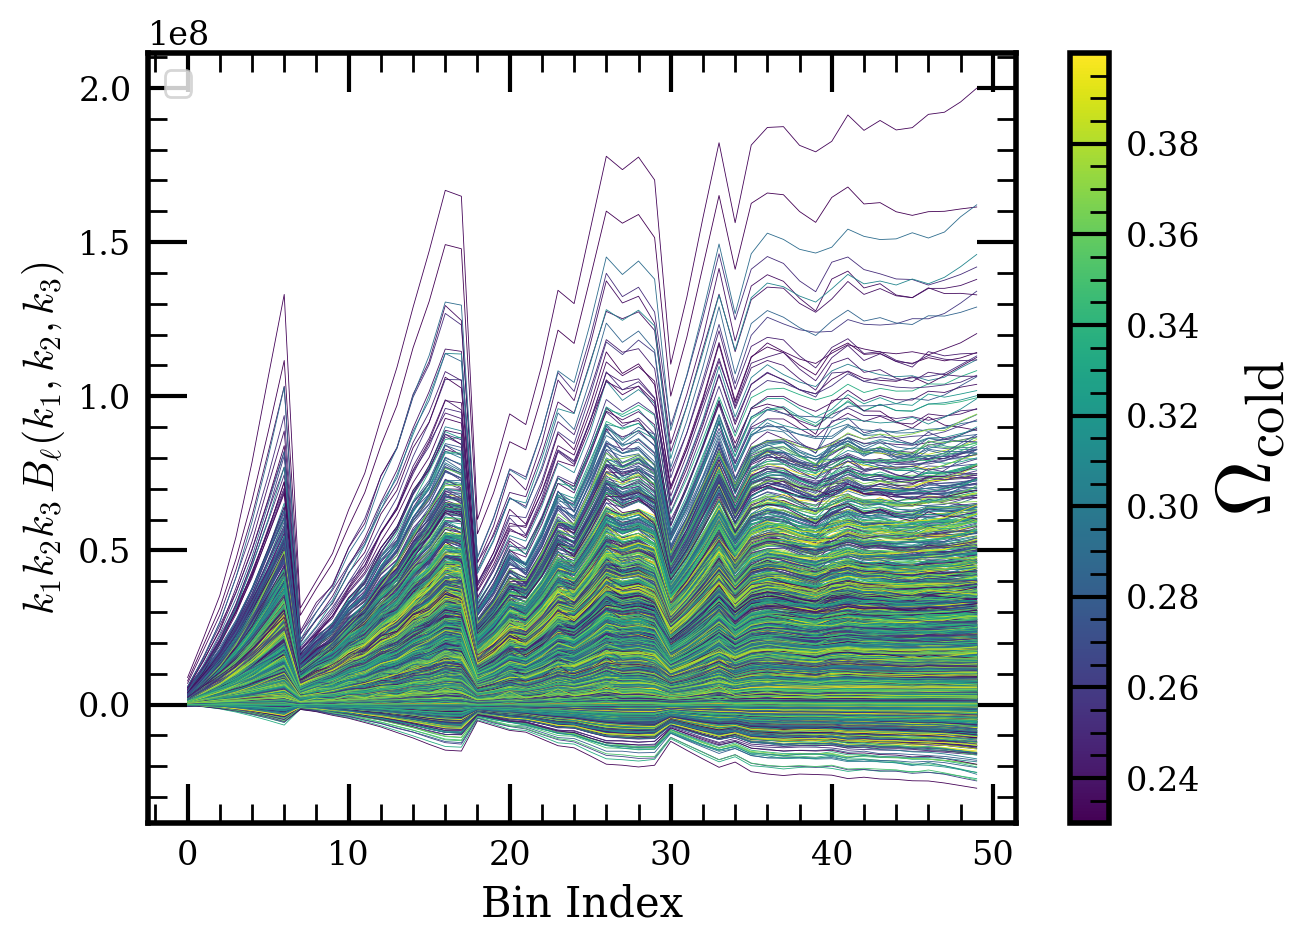

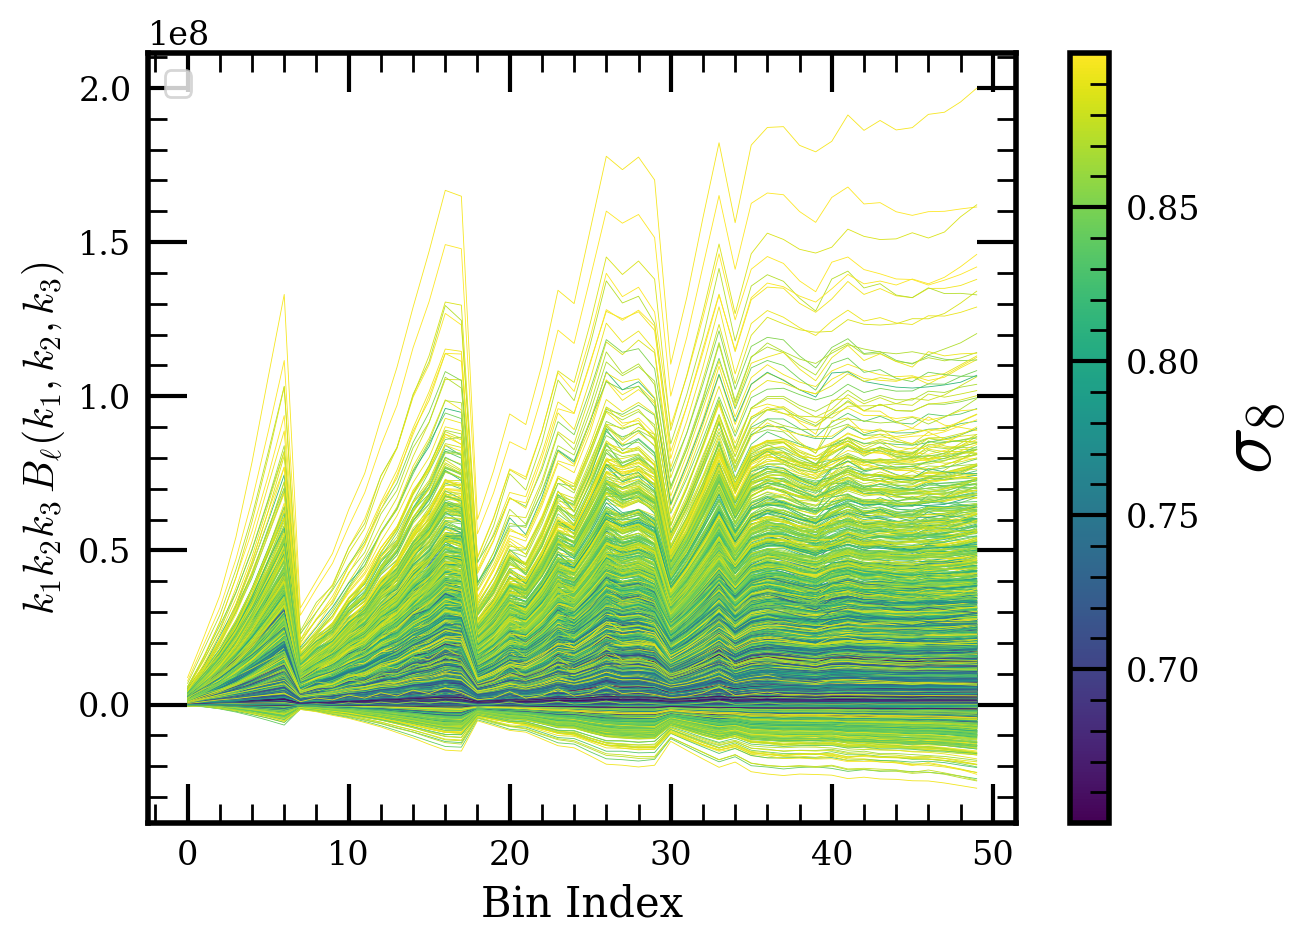

In [ ]:
n_grid = 128
norm = n_grid**3


param_names_show = ['omega_cold', 'sigma8_cold']
for pp, param_name_show in enumerate(param_names_show):
    
    param_vals = np.array(params_df[param_name_show])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    #colors = sm.to_rgba(param_vals)

    plt.figure(figsize=(7,5))

    for i, bk in enumerate(bk0s):
        # need to un-normalize bc the field was already normalized, and the 
        # bispec code is doing extra normalization
        # cube the norm because it's the bispectrum
        param_val = params_df.iloc[idxs_mock[i]][param_name_show]
        color = sm.to_rgba(param_val)
        plt.plot(norm**3 * weight*bk, lw=0.3, color=color)
            
    bk0s = np.array(bk0s)
            
    plt.xlabel(r'Bin Index',fontsize=15)
    plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)

    #cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    #cbar.set_label(utils.param_label_dict[param_name_show])
    fig = plt.gcf()
    fig.colorbar(sm, ax=plt.gca(), label=utils.param_label_dict[param_name_show])


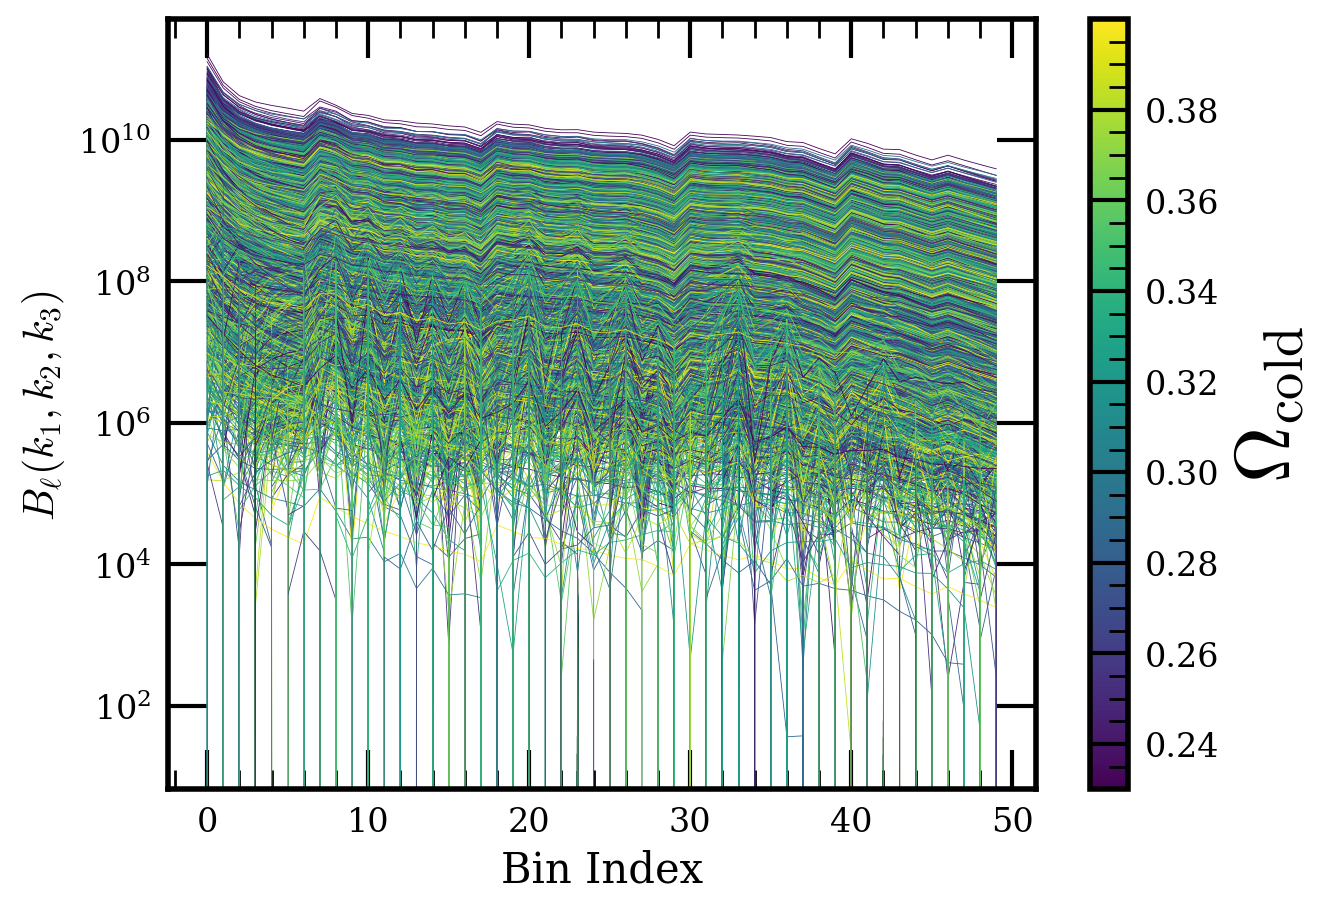

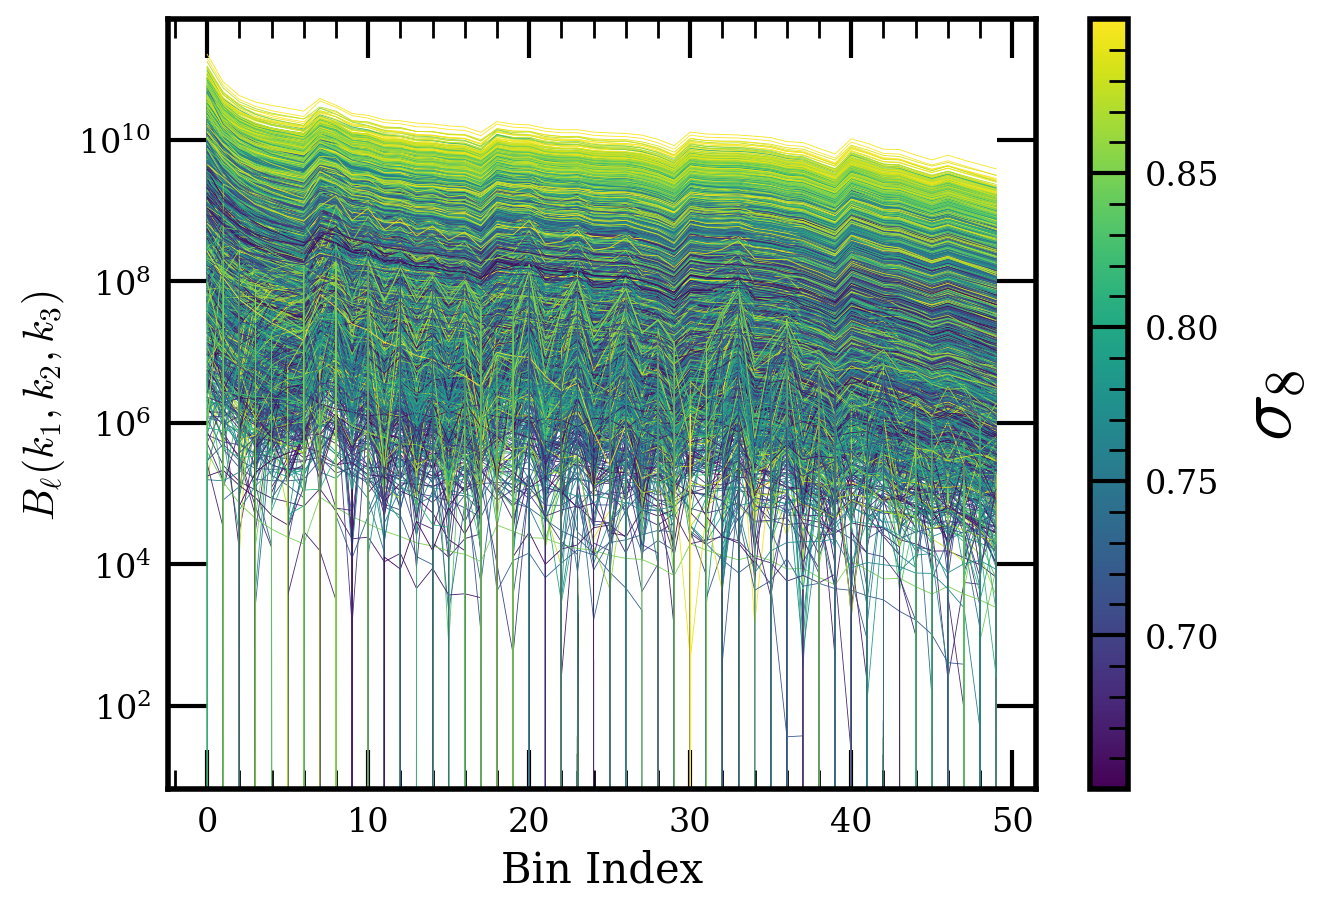

In [47]:
n_grid = 128
norm = n_grid**3


param_names_show = ['omega_cold', 'sigma8_cold']
for pp, param_name_show in enumerate(param_names_show):
    
    param_vals = np.array(params_df[param_name_show])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    #colors = sm.to_rgba(param_vals)

    plt.figure(figsize=(7,5))

    for i, bk in enumerate(bk0s):
        # need to un-normalize bc the field was already normalized, and the 
        # bispec code is doing extra normalization
        # cube the norm because it's the bispectrum
        param_val = params_df.iloc[idxs_mock[i]][param_name_show]
        color = sm.to_rgba(param_val)
        plt.plot(norm**3 *bk, lw=0.3, color=color)
            
    bk0s = np.array(bk0s)
            
    plt.xlabel(r'Bin Index',fontsize=15)
    plt.ylabel(r'$B_\ell(k_1,k_2,k_3)$',fontsize=15)
    plt.yscale('log')

    #cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    #cbar.set_label(utils.param_label_dict[param_name_show])
    fig = plt.gcf()
    fig.colorbar(sm, ax=plt.gca(), label=utils.param_label_dict[param_name_show])
